[윤기태 / 패스트캠퍼스] 최종 수정일 : 2018. 07. 24

## 데이터 분석을 위한 파이썬 프로그래밍 CAMP - 8주차

### *개발 환경 및 사용 라이브러리*
- 개발환경 : OSX 10.13.2, Anaconda-spyder IDE
- 개발언어 : Python 3.6.1
- 사용모듈 : pandas, numpy, matplotlib

-----

### 1. 필요한 라이브러리 및 데이터 가져오기

- %matplotlib inline : 주피터 노트북에서 그래프 그릴 것을 선언해줌.
- \# -*- coding: utf-8 -*- : 인코딩 타입은 utf-8 이라는 것을 선언.
- 데이터 frame 형태로 데이터를 관찰하고, 원하는 형태로 조작하기 위해 pandas와 numpy 라이브러리가 필요함.
- 원하는 형태로 데이터를 조작하였으면, 이를 시각화 하기 위해 matplotlib 라이브러리도 필요.

titanic_dataset.csv는 학습에 필요한 training dataset이고, answer.csv는 오로지 평가만을 위한 test 데이터셋.

In [23]:
%matplotlib inline

In [57]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

titanic = pd.read_csv("dataset/titanic_dataset.csv")
answer = pd.read_csv("dataset/titanic_answer.csv")
titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT"
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH"
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba"
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,36209,7.7250,NaN,Q,NaN,NaN
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


In [58]:
print(titanic.shape) # 데이터셋의 크기 살펴보기
print(titanic.columns) # 데이터셋의 피처 살펴보기

(916, 13)
Index(['pclass', 'survived', 'name', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'cabin', 'embarked', 'body', 'home.dest'],
      dtype='object')


- 훈련셋과 평가셋 데이터에서, 어떤 피처들에 결측값이 존재하는지 관찰해야 함.
- 훈련셋에서만 결측값을 확인한다면, 후에 모델링 할 때 feature가 맞지 않아 error 발생 확률이 높음.

In [59]:
titanic.isnull().sum()

pclass         0
survived       0
name           0
sex            0
age          175
sibsp          0
parch          0
ticket         0
fare           0
cabin        702
embarked       2
body         831
home.dest    389
dtype: int64

In [60]:
answer.isnull().sum()

pclass         0
survived       0
name           0
sex            0
age           88
sibsp          0
parch          0
ticket         0
fare           0
cabin        312
embarked       0
body         357
home.dest    175
dtype: int64

### 2. 피처 엔지니어링 없이, 간단한 전처리로 1차 학습

- 나이 : 결측값을 평균값으로 보정
- 성별 : binary categorical 변수를 0,1로 치환
- Embarked : 
- 1, 범주를 먼저 살펴본 뒤, outlier 제거
- 2, 결측값은 최빈값으로 보정하고, 범주형 변수이므로 one-hot encoding 적용.

In [61]:
# Age의 NaN값을 Age들의 평균으로 보정
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)

titanic.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,body,home.dest,C,Q,S
0,2,1,"Mellinger, Miss. Madeleine Violet",1,13.000000,0,1,250644,19.5000,NaN,S,NaN,"England / Bennington, VT",0,0,1
1,2,1,"Wells, Miss. Joan",1,4.000000,1,1,29103,23.0000,NaN,S,NaN,"Cornwall / Akron, OH",0,0,1
2,2,1,"Duran y More, Miss. Florentina",1,30.000000,1,0,SC/PARIS 2148,13.8583,NaN,C,NaN,"Barcelona, Spain / Havana, Cuba",1,0,0
3,3,0,"Scanlan, Mr. James",0,30.231444,0,0,36209,7.7250,NaN,Q,NaN,NaN,0,1,0
4,3,1,"Bradley, Miss. Bridget Delia",1,22.000000,0,0,334914,7.7250,NaN,Q,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls...",0,1,0


#### 어떤 변수가 생존에 유의미한 결과를 미치는지 시각적으로 탐색
#### pclass, age, sibsp, parch, fare 등으로 탐색

- age : 평균으로 보정한 age 변수는 생존 집단과 비생존 집단의 유의미한 차이 없음
- 나머지는 기준에 따라 다르지만, 대체적으로 유의미한 차이가 있음.

In [62]:
# 반복 작업으로 평가해주는 변수 탐색작업을 자동화
# 연속형 변수를 파라미터로 입력
import seaborn as sns
from scipy import stats

def valid_features(col_name):
    g = sns.FacetGrid(titanic, col='survived')
    g.map(plt.hist, col_name, bins=20)

    titanic_survived = titanic[titanic['survived']==1]
    titanic_survived_static = np.array(titanic_survived[col_name])
    print("data length is", '%.2f' % len(titanic_survived_static))
    print("data mean is", '%.2f' % np.mean(titanic_survived_static))
    print("data variance is", '%.2f' % np.var(titanic_survived_static))
    print("data std is", '%.2f' % np.std(titanic_survived_static))
    print("data max is", '%.2f' % np.max(titanic_survived_static))
    print("data min is", '%.2f' % np.min(titanic_survived_static))
    print("data median is", '%.2f' % np.median(titanic_survived_static))
    print("-----------------------")

    titanic_n_survived = titanic[titanic['survived']==0]
    titanic_n_survived_static = np.array(titanic_n_survived[col_name])
    print("data length is", '%.2f' % len(titanic_n_survived_static))
    print("data mean is", '%.2f' % np.mean(titanic_n_survived_static))
    print("data variance is", '%.2f' % np.var(titanic_n_survived_static))
    print("data std is", '%.2f' % np.std(titanic_n_survived_static))
    print("data max is", '%.2f' % np.max(titanic_n_survived_static))
    print("data min is", '%.2f' % np.min(titanic_n_survived_static))
    print("data median is", '%.2f' % np.median(titanic_n_survived_static))
    print("-----------------------")

    tTestResult = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name])
    tTestResultDiffVar = stats.ttest_ind(titanic_survived[col_name], titanic_n_survived[col_name], equal_var=False)

    print("The t-statistic and p-value assuming equal variances is %.3f and %.3f." % tTestResult)
    print("The t-statistic and p-value not assuming equal variances is %.3f and %.3f" % tTestResultDiffVar)

data length is 353.00
data mean is 29.94
data variance is 175.25
data std is 13.24
data max is 64.00
data min is 0.17
data median is 30.23
-----------------------
data length is 563.00
data mean is 30.41
data variance is 145.24
data std is 12.05
data max is 74.00
data min is 0.75
data median is 30.23
-----------------------
The t-statistic and p-value assuming equal variances is -0.553 and 0.581.
The t-statistic and p-value not assuming equal variances is -0.541 and 0.589


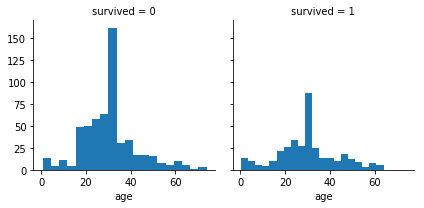

In [63]:
valid_features('age')

data length is 353.00
data mean is 0.43
data variance is 0.42
data std is 0.64
data max is 4.00
data min is 0.00
data median is 0.00
-----------------------
data length is 563.00
data mean is 0.60
data variance is 1.79
data std is 1.34
data max is 8.00
data min is 0.00
data median is 0.00
-----------------------
The t-statistic and p-value assuming equal variances is -2.118 and 0.034.
The t-statistic and p-value not assuming equal variances is -2.446 and 0.015


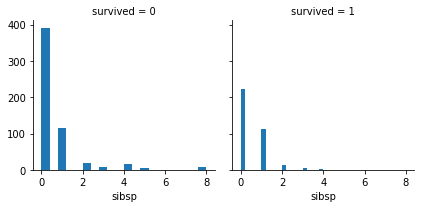

In [64]:
valid_features('sibsp')

data length is 353.00
data mean is 0.44
data variance is 0.55
data std is 0.74
data max is 4.00
data min is 0.00
data median is 0.00
-----------------------
data length is 563.00
data mean is 0.33
data variance is 0.79
data std is 0.89
data max is 9.00
data min is 0.00
data median is 0.00
-----------------------
The t-statistic and p-value assuming equal variances is 1.865 and 0.063.
The t-statistic and p-value not assuming equal variances is 1.942 and 0.052


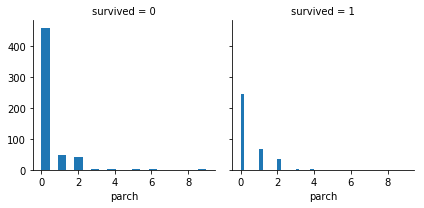

In [65]:
valid_features('parch')

data length is 353.00
data mean is 46.98
data variance is 3682.38
data std is 60.68
data max is 512.33
data min is 0.00
data median is 26.00
-----------------------
data length is 563.00
data mean is 23.47
data variance is 1132.13
data std is 33.65
data max is 263.00
data min is 0.00
data median is 12.18
-----------------------
The t-statistic and p-value assuming equal variances is 7.523 and 0.000.
The t-statistic and p-value not assuming equal variances is 6.657 and 0.000


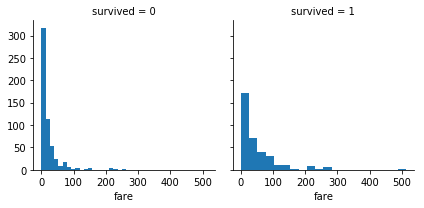

In [66]:
valid_features('fare')

#### 범주형 변수에 대한 탐색

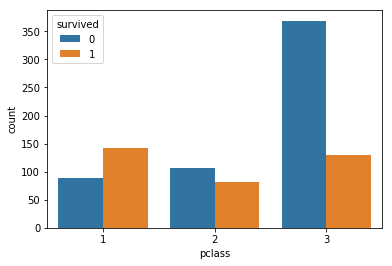

In [67]:
ax = sns.countplot(x='pclass', hue = 'survived',  data = titanic)

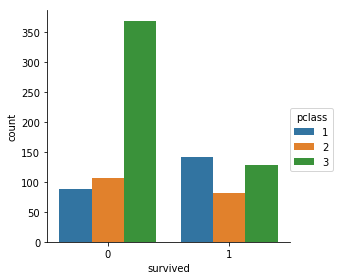

In [68]:
ax = sns.factorplot('survived', data=titanic, kind='count', hue='pclass')

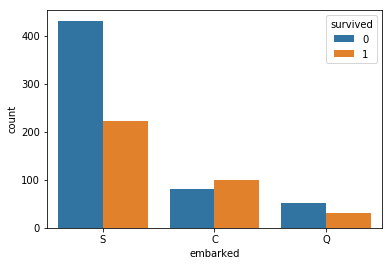

In [69]:
ax = sns.countplot(x='embarked', hue = 'survived',  data = titanic)

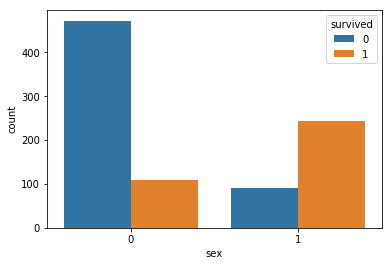

In [70]:
ax = sns.countplot(x='sex', hue = 'survived',  data = titanic)

#### 변수간의 관계 인사이트

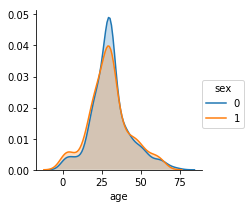

In [71]:
fig = sns.FacetGrid(titanic, hue='sex')
fig.map(sns.kdeplot, 'age', shade=True)
fig.add_legend()

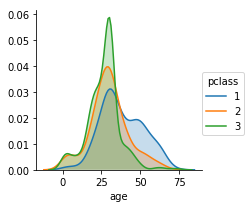

In [72]:
fig = sns.FacetGrid(titanic, hue='pclass')
fig.map(sns.kdeplot, 'age', shade=True)
fig.add_legend()

### 지금까지의 탐색 결과 및 feature 정리

- Training dataset을 Training dataset, validation dataset으로 분리
- 추가적인 핸들링이 별도로 필요해보이는 피처나, 결과에 무의미한 영향을 미치는 것 처럼 보이는 변수들을 제거
- 'Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked' 만 1차 학습에서 선택

In [73]:
# name, cabin 변수는 전처리 및 핸들링이 필요해 보이므로 일단 제외.
# ticket, body, home.dest는 무의미한 피처로 보이므로 제외.
titanic = titanic.drop(['name', 'cabin', 'ticket', 'body', 'home.dest'], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

# train, validation set 분리.
from sklearn.model_selection import train_test_split
train, valid = train_test_split(titanic, test_size=0.2, random_state=0)

train_y = train['survived']
train_x = train.drop(['survived'], axis=1)

valid_y = valid['survived']
valid_x = valid.drop(['survived'], axis=1)

- 학습 직전, 최종적으로 정리된 피처의 데이터 프레임

In [74]:
train_x.head()

,pclass,sex,age,sibsp,parch,fare,C,Q,S
511,1,0,29.000000,1,0,66.6000,0,0,1
527,1,0,30.231444,0,0,227.5250,1,0,0
85,1,1,30.000000,0,0,93.5000,0,0,1
413,2,0,27.000000,1,0,26.0000,0,0,1
75,3,0,40.000000,0,0,7.8958,0,0,1


### 3. 정리된 피처를 이용하여, 로지스틱 회귀로 원시 분류모델 학습

- 로지스틱 회귀로 학습한 뒤, 제대로 분류되지 않은 case를 단순 count로 검출.

In [75]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(train_x, train_y)
pred_y = lr.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 43


### 4. 1차 학습 모델 평가 (test set이 아닌 valid set으로)

In [76]:
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.77
Precision : 0.691
Recall : 0.681
F1 : 0.686


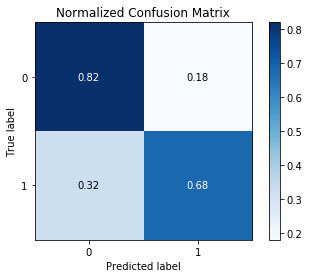

In [77]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(valid_y, pred_y, normalize=True)
plt.show()

-----

-----

# 모델 성능 개선 : Feature Engineering, Feature Selection 적용

### 5. 학습에 활용되는 피처 재선정 - 데이터 핸들링 및 전처리

- 피처를 핸들링하고, 텍스트 형태이거나 rough한 범주형 데이터에서 의미를 찾아내는 작업.
- 불필요한 피처들을 선정하고, 활용 가능성이 있는 피처를 핸들링하여 활용 가능하게 만드는 단계

-----

- ticket, body, home.dest는 확실히 무의미한 피처로 보이므로 제외.

In [78]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)
titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,embarked
0,2,1,"Mellinger, Miss. Madeleine Violet",female,13.0,0,1,19.5000,NaN,S
1,2,1,"Wells, Miss. Joan",female,4.0,1,1,23.0000,NaN,S
2,2,1,"Duran y More, Miss. Florentina",female,30.0,1,0,13.8583,NaN,C
3,3,0,"Scanlan, Mr. James",male,NaN,0,0,7.7250,NaN,Q
4,3,1,"Bradley, Miss. Bridget Delia",female,22.0,0,0,7.7250,NaN,Q


- sex 변수와 embarked 변수도 처리방법이 명확하게 정해져 있으므로 위에서와 마찬가지로 처리

In [79]:
# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,C,Q,S
0,2,1,"Mellinger, Miss. Madeleine Violet",1,13.0,0,1,19.5000,NaN,0,0,1
1,2,1,"Wells, Miss. Joan",1,4.0,1,1,23.0000,NaN,0,0,1
2,2,1,"Duran y More, Miss. Florentina",1,30.0,1,0,13.8583,NaN,1,0,0
3,3,0,"Scanlan, Mr. James",0,NaN,0,0,7.7250,NaN,0,1,0
4,3,1,"Bradley, Miss. Bridget Delia",1,22.0,0,0,7.7250,NaN,0,1,0


- cabin 변수를 처리하기 위해 살펴보기 
--> 알파벳에 따라 유의미한 결과가 나올 것이라는 가설

In [80]:
titanic['cabin'].value_counts()

C23 C25 C27    5
G6             4
C78            4
E34            3
F4             3
B96 B98        3
C22 C26        3
A34            3
F33            3
E101           3
F2             3
C68            2
B69            2
C101           2
E33            2
C54            2
B71            2
C6             2
B28            2
B35            2
C65            2
D33            2
C7             2
C83            2
F G63          2
E67            2
E31            2
C126           2
C92            2
E50            2
              ..
E77            1
E38            1
C124           1
B3             1
D21            1
A24            1
C128           1
D9             1
E24            1
D46            1
C85            1
C51            1
C103           1
B45            1
C130           1
E44            1
B50            1
E63            1
B86            1
D50            1
C105           1
B41            1
B24            1
B49            1
C2             1
B30            1
F              1
A14           

In [81]:
titanic['cabin'] = titanic['cabin'].fillna('X') # 캐비닛이 없는 경우 X라는 알파벳으로 대체
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])

In [82]:
titanic['cabin'].value_counts()

X    702
C     71
B     42
E     32
D     32
A     17
F     15
G      4
T      1
Name: cabin, dtype: int64

- cabin에 따라 생존률이 어떻게 달라지는지 관찰하기

In [83]:
cabin_group = titanic.groupby('cabin')['survived']

In [84]:
cabin_group.value_counts()

cabin  survived
A      1             9
       0             8
B      1            32
       0            10
C      1            40
       0            31
D      1            23
       0             9
E      1            23
       0             9
F      1            10
       0             5
G      0             2
       1             2
T      0             1
X      0           488
       1           214
Name: survived, dtype: int64

- X, T 정도를 제외하면 대부분 캐비닛이 있는 쪽이 생존률이 높음. 이 중 특히 B, D, E, F 의 생존률이 높아보임. 의미 있는 피처로 선정.
- 단, G, T는 모수가 너무 적으므로 X로 통일.
- one-hot encoding을 고려하여 test 데이터에서도 같은 범주의 변수인지 확인 필요

In [85]:
# one-hot encoding을 고려하여 test 데이터에서도 같은 범주의 변수인지 확인 -> T 범주가 없으므로 test set에서 T를 X로 통일.
answer = pd.read_csv("dataset/titanic_answer.csv")
answer['cabin'] = answer['cabin'].fillna('X')
answer['cabin'] = answer['cabin'].apply(lambda x: x[0])
answer['cabin'].value_counts()

X    312
B     23
C     23
D     14
E      9
F      6
A      5
G      1
Name: cabin, dtype: int64

#### 지금까지의 피처 다시한번 정리

In [86]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

titanic['cabin'] = titanic['cabin'].fillna('X') # 캐비닛이 없는 경우 X라는 알파벳으로 대체
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])
titanic['cabin'] = titanic['cabin'].replace({"G":"X", "T":"X"}) # G,T도 X로 대체

In [87]:
titanic.head(5)

,pclass,survived,name,sex,age,sibsp,parch,fare,cabin,C,Q,S
0,2,1,"Mellinger, Miss. Madeleine Violet",1,13.0,0,1,19.5000,X,0,0,1
1,2,1,"Wells, Miss. Joan",1,4.0,1,1,23.0000,X,0,0,1
2,2,1,"Duran y More, Miss. Florentina",1,30.0,1,0,13.8583,X,1,0,0
3,3,0,"Scanlan, Mr. James",0,NaN,0,0,7.7250,X,0,1,0
4,3,1,"Bradley, Miss. Bridget Delia",1,22.0,0,0,7.7250,X,0,1,0


- 다음으로, name 피처에 대한 활용법 고민.
- name 피처를 살펴본 결과 miss, mr 등 대략적인 성별이나 지위를 나타내는 호칭이 대부분 붙어있음을 확인.
- 따라서 이를 추출해내는 전처리 활용

In [88]:
name_grade = titanic['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0]) # 호칭만 추출해내는 방법
name_grade2 = answer['name'].apply(lambda x : x.split(", ",1)[1].split(".")[0])

In [89]:
name_grade = name_grade.unique().tolist()
name_grade2 = name_grade2.unique().tolist()
for grade in name_grade2:
    if grade in name_grade:
        pass
    else:
        name_grade.append(grade)
print(name_grade)

['Miss', 'Mr', 'Master', 'Mrs', 'Dr', 'Mlle', 'Col', 'Rev', 'Ms', 'Mme', 'Sir', 'the Countess', 'Dona', 'Jonkheer', 'Lady', 'Major', 'Don', 'Capt']


In [90]:
# 호칭에 따라 등급을 분류하는 함수. 같은 호칭을 부르는 말은 같은 grade로 통합
def mr_grade(row):
    # 명예직
    if 'Rev.' in row:
        return "A"
    elif 'Col.' in row:
        return "A"
    elif 'Major.' in row:
        return "A"
    elif 'Dr.' in row:
        return "A"
    elif 'Capt.' in row:
        return "A"
    elif 'Sir.' in row:
        return "A"
    # 여성
    elif 'Ms.' in row:
        return "B"
    elif 'Mme.' in row:
        return "B"
    elif 'Mrs.' in row:
        return "B"
    elif 'Dona.' in row:
        return "D"
    # 귀족, 작위
    elif 'Jonkheer.' in row:
        return "C"
    elif 'Countess.' in row:
        return "C"
    # 남성
    elif 'Mr.' in row:
        return "D"
    elif 'Don.' in row:
        return "D"
    # 젊은남성
    elif 'Master.' in row:
        return "E"
    # 젊은여성
    elif 'Miss.' in row:
        return "F"
    elif 'Mlle.' in row:
        return "F"
    elif 'Lady.' in row:
        return "F"
    else:
        return "G"
    
titanic['name_grade'] = titanic.apply(lambda row: mr_grade(row['name']), axis=1)

In [91]:
titanic['name_grade'].value_counts()

D    524
F    188
B    144
E     40
A     18
C      2
Name: name_grade, dtype: int64

In [92]:
titanic = titanic.drop(['name'], axis=1)
titanic.head(5)

,pclass,survived,sex,age,sibsp,parch,fare,cabin,C,Q,S,name_grade
0,2,1,1,13.0,0,1,19.5000,X,0,0,1,F
1,2,1,1,4.0,1,1,23.0000,X,0,0,1,F
2,2,1,1,30.0,1,0,13.8583,X,1,0,0,F
3,3,0,0,NaN,0,0,7.7250,X,0,1,0,D
4,3,1,1,22.0,0,0,7.7250,X,0,1,0,F


### 6. 결측값 처리 & 숨겨진 의도 발굴 & 새로운 피처 생성 완료한 데이터셋으로 학습

- 현재까지의 피처 정리
- 연속형 변수 age ~ fare는 cabin, name의 핸들링 결과를 확인한 뒤 후처리

In [93]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)

# age : 나이는 평균값으로 보정
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

# cabin : 없는 경우, G나 T는 X로 대체한 뒤 one hot encoding 적용
titanic['cabin'] = titanic['cabin'].fillna('X')
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])
titanic['cabin'] = titanic['cabin'].replace({"G":"X", "T":"X"})

df_one_hot_encoded = pd.get_dummies(titanic.cabin)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['cabin'], axis=1)

# 호칭에 따라 등급을 분류하는 함수. 같은 호칭을 부르는 말은 같은 grade로 통합
def mr_grade(row):
    # 명예직
    if 'Rev.' in row:
        return "A"
    elif 'Col.' in row:
        return "A"
    elif 'Major.' in row:
        return "A"
    elif 'Dr.' in row:
        return "A"
    elif 'Capt.' in row:
        return "A"
    elif 'Sir.' in row:
        return "A"
    # 여성
    elif 'Ms.' in row:
        return "B"
    elif 'Mme.' in row:
        return "B"
    elif 'Mrs.' in row:
        return "B"
    elif 'Dona.' in row:
        return "D"
    # 귀족, 작위
    elif 'Jonkheer.' in row:
        return "C"
    elif 'Countess.' in row:
        return "C"
    # 남성
    elif 'Mr.' in row:
        return "D"
    elif 'Don.' in row:
        return "D"
    # 젊은남성
    elif 'Master.' in row:
        return "E"
    # 젊은여성
    elif 'Miss.' in row:
        return "F"
    elif 'Mlle.' in row:
        return "F"
    elif 'Lady.' in row:
        return "F"
    else:
        return "G"

# name_grade 피처 생성하고 one-hot encoding 적용
titanic['name'] = titanic.apply(lambda row: mr_grade(row['name']), axis=1)

df_one_hot_encoded = pd.get_dummies(titanic.name)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['name'], axis=1)

# pclass one-hot encoding 적용
df_one_hot_encoded = pd.get_dummies(titanic.pclass)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['pclass'], axis=1)

titanic.head()

,survived,sex,age,sibsp,parch,fare,C,Q,S,A,...,X,A,B,C,D,E,F,1,2,3
0,1,1,13.000000,0,1,19.5000,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,1,1,4.000000,1,1,23.0000,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,1,30.000000,1,0,13.8583,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
3,0,0,30.231444,0,0,7.7250,0,1,0,0,...,1,0,0,0,1,0,0,0,0,1
4,1,1,22.000000,0,0,7.7250,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1


- 훈련, 검증셋 나눠서 2차 학습

In [94]:
train, valid = train_test_split(titanic, test_size=0.2, random_state=0)

train_y = train['survived']
train_x = train.drop(['survived'], axis=1)

valid_y = valid['survived']
valid_x = valid.drop(['survived'], axis=1)

In [95]:
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(train_x, train_y)
pred_y = lr.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 33


In [96]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.82
Precision : 0.765
Recall : 0.754
F1 : 0.759


- 성능이 향상되었음을 확인하고, 연속형 변수에 대한 피처 엔지니어링 작업 실행

-----

### 7. 피처 엔지니어링

- 수치와 관련된 엔지니어링을 하는 단계
- 수치형 변수들에 대한 outlier에 대한 검증 필요
- 수치형 변수들에 대한 scaling
- 변수간의 공선성, 상관관계 검증하여 모델 최적화
- 평균값으로 보정한 age값을 regression으로 정교화

-----

#### outlier 검증

0    707
1    115
2     79
3      5
4      4
5      3
6      2
9      1
Name: parch, dtype: int64


{'boxes': [<matplotlib.lines.Line2D at 0x10ac75780>],
 'caps': [<matplotlib.lines.Line2D at 0x10aed1358>,
 'fliers': [<matplotlib.lines.Line2D at 0x10aed1d68>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10aed1f60>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1099064e0>,
  <matplotlib.lines.Line2D at 0x109906748>]}

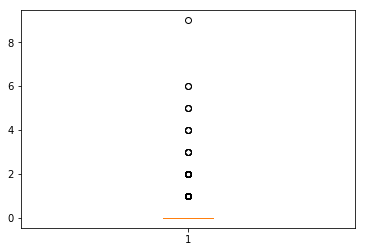

In [97]:
print(titanic['parch'].value_counts()) # 직계가족 수의 경우, 통계적으로는 outlier가 검출되지만 최대값인 9도 잘못된 값으로 보기는 어려움
plt.boxplot(titanic['parch'])

0    615
1    227
2     32
4     16
3     12
8      9
5      5
Name: sibsp, dtype: int64


{'boxes': [<matplotlib.lines.Line2D at 0x10b1f64a8>],
 'caps': [<matplotlib.lines.Line2D at 0x10aa2b4e0>,
 'fliers': [<matplotlib.lines.Line2D at 0x10aa079e8>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10aa07518>],
 'whiskers': [<matplotlib.lines.Line2D at 0x10aa19da0>,
  <matplotlib.lines.Line2D at 0x10aa19438>]}

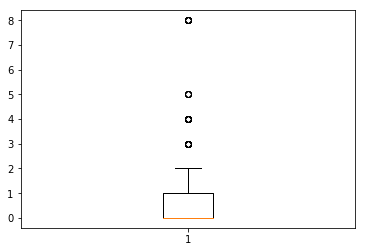

In [98]:
print(titanic['sibsp'].value_counts()) # 형제자매, 배우자 역시 마찬가지
plt.boxplot(titanic['sibsp'])

In [99]:
sorted(titanic['age'].value_counts().index.tolist()) # 나이 역시 이상치 없음

[0.17,
 0.75,
 0.83,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 11.5,
 12.0,
 13.0,
 14.0,
 14.5,
 15.0,
 16.0,
 17.0,
 18.0,
 18.5,
 19.0,
 20.0,
 21.0,
 22.0,
 22.5,
 23.0,
 23.5,
 24.0,
 25.0,
 26.0,
 26.5,
 27.0,
 28.0,
 28.5,
 29.0,
 30.0,
 30.23144399460189,
 30.5,
 31.0,
 32.0,
 32.5,
 33.0,
 34.0,
 35.0,
 36.0,
 36.5,
 37.0,
 38.0,
 38.5,
 39.0,
 40.0,
 40.5,
 41.0,
 42.0,
 43.0,
 44.0,
 45.0,
 45.5,
 46.0,
 47.0,
 48.0,
 49.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 65.0,
 66.0,
 67.0,
 70.5,
 71.0,
 74.0]

{'boxes': [<matplotlib.lines.Line2D at 0x10a0169e8>],
 'caps': [<matplotlib.lines.Line2D at 0x10ac00630>,
 'fliers': [<matplotlib.lines.Line2D at 0x109f87160>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x10ac00e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x1099a05f8>,
  <matplotlib.lines.Line2D at 0x1099a0cf8>]}

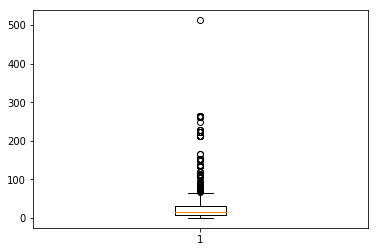

In [100]:
plt.boxplot(titanic['fare']) # 요금의 경우, 통계적 이상치 존재

(array([ 747.,  111.,   30.,    2.,   16.,    9.,    0.,    0.,    0.,    1.]),
 array([   0.     ,   51.23292,  102.46584,  153.69876,  204.93168,
         256.1646 ,  307.39752,  358.63044,  409.86336,  461.09628,
         512.3292 ]),
 <a list of 10 Patch objects>)

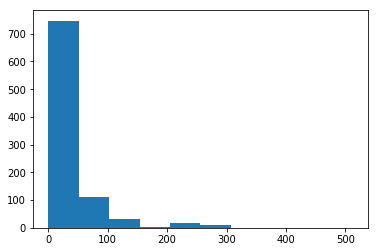

In [101]:
plt.hist(titanic['fare'])

In [102]:
rich_group = titanic[titanic['fare'] > 200]
n_rich_group = titanic[titanic['fare'] <= 200]
print(rich_group['survived'].value_counts())
print(n_rich_group['survived'].value_counts()) # 이상치 그룹의 생존률을 살펴본 결과, 이상치라기 보다는 유의미한 explode 값으로 보임

1    18
0     8
Name: survived, dtype: int64
0    555
1    335
Name: survived, dtype: int64


-----

#### 변수간의 상관성 검증

- 연속형 변수간의 상관관계 없음

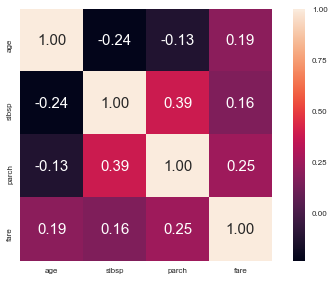

In [103]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic[titanic['age'].notnull()]

cols = ['age', 'sibsp', 'parch', 'fare']

cm = np.corrcoef(titanic[['age', 'sibsp', 'parch', 'fare']].values.T)
sns.set(font_scale=0.8)
hm = sns.heatmap(cm,
            cbar=True,
            annot=True,
            square=True,
            fmt='.2f',
            annot_kws={'size': 15},
            yticklabels=cols,
            xticklabels=cols)

plt.tight_layout()
plt.show()

-----

#### 평균값으로 보정한 age값을 regression으로 정교화

In [104]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

# cabin : 없는 경우, G나 T는 X로 대체한 뒤 one hot encoding 적용
titanic['cabin'] = titanic['cabin'].fillna('X')
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])
titanic['cabin'] = titanic['cabin'].replace({"G":"X", "T":"X"})

df_one_hot_encoded = pd.get_dummies(titanic.cabin)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['cabin'], axis=1)

# 호칭에 따라 등급을 분류하는 함수. 같은 호칭을 부르는 말은 같은 grade로 통합
def mr_grade(row):
    # 명예직
    if 'Rev.' in row:
        return "A"
    elif 'Col.' in row:
        return "A"
    elif 'Major.' in row:
        return "A"
    elif 'Dr.' in row:
        return "A"
    elif 'Capt.' in row:
        return "A"
    elif 'Sir.' in row:
        return "A"
    # 여성
    elif 'Ms.' in row:
        return "B"
    elif 'Mme.' in row:
        return "B"
    elif 'Mrs.' in row:
        return "B"
    elif 'Dona.' in row:
        return "D"
    # 귀족, 작위
    elif 'Jonkheer.' in row:
        return "C"
    elif 'Countess.' in row:
        return "C"
    # 남성
    elif 'Mr.' in row:
        return "D"
    elif 'Don.' in row:
        return "D"
    # 젊은남성
    elif 'Master.' in row:
        return "E"
    # 젊은여성
    elif 'Miss.' in row:
        return "F"
    elif 'Mlle.' in row:
        return "F"
    elif 'Lady.' in row:
        return "F"
    else:
        return "G"

# name_grade 피처 생성하고 one-hot encoding 적용
titanic['name'] = titanic.apply(lambda row: mr_grade(row['name']), axis=1)

df_one_hot_encoded = pd.get_dummies(titanic.name)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['name'], axis=1)

# pclass one-hot encoding 적용
df_one_hot_encoded = pd.get_dummies(titanic.pclass)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['pclass'], axis=1)

titanic.head()

# 결측이 있는 데이터, 없는 데이터로 분리
titanic = titanic[titanic['age'].notnull()]
no_age_titanic = titanic[titanic['age'].isnull()]

titanic.head()

,survived,sex,age,sibsp,parch,fare,C,Q,S,A,...,X,A,B,C,D,E,F,1,2,3
0,1,1,13.0,0,1,19.5000,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,1,1,4.0,1,1,23.0000,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,1,30.0,1,0,13.8583,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,1,1,22.0,0,0,7.7250,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
6,1,1,30.0,0,0,56.9292,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


- 모든 피처로 regression 모델 학습 : 결과는 예측 실패

In [105]:
# train, validation set 분리.
train, valid = train_test_split(titanic, test_size=0.2, random_state=0)

train_y = train['age']
train_x = train.drop(['age'], axis=1)

valid_y = valid['age']
valid_x = valid.drop(['age'], axis=1)

# Randomforest Regressor 학습
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

regr = RandomForestRegressor()
regr.fit(train_x, train_y)
pred_y = regr.predict(valid_x)

print("Mean squared error: %.2f"% mean_squared_error(valid_y, pred_y))
print('Variance score: %.2f' % r2_score(valid_y, pred_y))

importances = regr.feature_importances_
feat_labels = train_x.columns.values
indices = np.argsort(importances)[::-1]
for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Mean squared error: 118.63
Variance score: 0.38
 1) fare                           0.259234
 2) 1                              0.175577
 3) E                              0.119166
 4) parch                          0.108917
 5) F                              0.080532
 6) sibsp                          0.042585
 7) B                              0.027789
 8) survived                       0.027562
 9) D                              0.026229
10) S                              0.019423
11) 2                              0.015171
12) C                              0.011338
13) C                              0.010920
14) A                              0.010534
15) Q                              0.009872
16) E                              0.008670
17) sex                            0.008086
18) B                              0.008053
19) 3                              0.007891
20) X                              0.007160
21) D                              0.006979
22) A                       

- 피처를 다시 선택하여 학습 : 결과는 처참

In [106]:
titanic = titanic[['survived', 'age', 'sibsp', 'parch', 'fare']]

# train, validation set 분리.
train, valid = train_test_split(titanic, test_size=0.2, random_state=0)

train_y = train['age']
train_x = train.drop(['age'], axis=1)

valid_y = valid['age']
valid_x = valid.drop(['age'], axis=1)

# Randomforest Regressor 학습
regr = RandomForestRegressor()
regr.fit(train_x, train_y)
pred_y = regr.predict(valid_x)

print("Mean squared error: %.2f"% mean_squared_error(valid_y, pred_y))
print('Variance score: %.2f' % r2_score(valid_y, pred_y))

importances = regr.feature_importances_
feat_labels = train_x.columns.values
indices = np.argsort(importances)[::-1]
for f in range(train_x.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, feat_labels[indices[f]], importances[indices[f]]))

Mean squared error: 154.17
Variance score: 0.19
 1) fare                           0.633759
 2) parch                          0.164957
 3) sibsp                          0.129042
 4) survived                       0.072242


- age는 prediction 하여 결측값을 처리하는 것이 불가능하다고 판단.

-----

-----

### 8. 3차 학습

- age 변수에 변화 : 결측값을 제대로 보정하기 힘들기 때문에 결측값을 제외하고 학습 (평가시에만 평균 보정)
- 통계적인 의미는 없었지만, child와 non-child로 구분하는 것이 의미가 있을 것이란 가설을 세우고 실험 진행
- fare 변수에 변화 : rich와 non-rich로 구분하는 것이 의미가 있을 것이란 가설을 세우고 실험 진행

In [107]:
titanic = pd.read_csv("dataset/titanic_dataset.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)

# age : 결측값을 제외하고 학습, child와 non-child로 구분하여 새로운 피처 생성
titanic = titanic[titanic['age'].notnull()]
titanic['child'] = 0
titanic.loc[titanic['age'] < 18, 'child'] = 1
titanic = titanic.drop(['age'], axis=1)

# fare : rich와 non-rich로 구분하여 새로운 피처 생성
titanic['royal'] = 0
titanic.loc[titanic['fare'] > 10, 'royal'] = 1
titanic = titanic.drop(['fare'], axis=1)

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

# cabin : 없는 경우, G나 T는 X로 대체한 뒤 one hot encoding 적용
titanic['cabin'] = titanic['cabin'].fillna('X')
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])
titanic['cabin'] = titanic['cabin'].replace({"G":"X", "T":"X"})

df_one_hot_encoded = pd.get_dummies(titanic.cabin)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['cabin'], axis=1)

# 호칭에 따라 등급을 분류하는 함수. 같은 호칭을 부르는 말은 같은 grade로 통합
def mr_grade(row):
    # 명예직
    if 'Rev.' in row:
        return "A"
    elif 'Col.' in row:
        return "A"
    elif 'Major.' in row:
        return "A"
    elif 'Dr.' in row:
        return "A"
    elif 'Capt.' in row:
        return "A"
    elif 'Sir.' in row:
        return "A"
    # 여성
    elif 'Ms.' in row:
        return "B"
    elif 'Mme.' in row:
        return "B"
    elif 'Mrs.' in row:
        return "B"
    elif 'Dona.' in row:
        return "D"
    # 귀족, 작위
    elif 'Jonkheer.' in row:
        return "C"
    elif 'Countess.' in row:
        return "C"
    # 남성
    elif 'Mr.' in row:
        return "D"
    elif 'Don.' in row:
        return "D"
    # 젊은남성
    elif 'Master.' in row:
        return "E"
    # 젊은여성
    elif 'Miss.' in row:
        return "F"
    elif 'Mlle.' in row:
        return "F"
    elif 'Lady.' in row:
        return "F"
    else:
        return "G"

# name_grade 피처 생성하고 one-hot encoding 적용
titanic['name'] = titanic.apply(lambda row: mr_grade(row['name']), axis=1)

df_one_hot_encoded = pd.get_dummies(titanic.name)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['name'], axis=1)

# pclass one-hot encoding 적용
df_one_hot_encoded = pd.get_dummies(titanic.pclass)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['pclass'], axis=1)

print(titanic.columns)
titanic.columns = ['survived',      'sex',    'sibsp',    'parch',    'child',    'royal',
              'C1',        'Q',        'S',        'A1',        'B1',        'C2',
              'D1',        'E1',        'F1',        'X',        'A2',        'B2',
              'C3',        'D2',        'E2',        'F2',          1,          2,
                3]
titanic.head()

Index(['survived',      'sex',    'sibsp',    'parch',    'child',    'royal',
              'C',        'Q',        'S',        'A',        'B',        'C',
              'D',        'E',        'F',        'X',        'A',        'B',
              'C',        'D',        'E',        'F',          1,          2,
                3],
      dtype='object')


,survived,sex,sibsp,parch,child,royal,C1,Q,S,A1,...,X,A2,B2,C3,D2,E2,F2,1,2,3
0,1,1,0,1,1,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
1,1,1,1,1,1,1,0,0,1,0,...,1,0,0,0,0,0,1,0,1,0
2,1,1,1,0,0,1,1,0,0,0,...,1,0,0,0,0,0,1,0,1,0
4,1,1,0,0,0,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,1
6,1,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,1,1,0,0


In [108]:
train, valid = train_test_split(titanic, test_size=0.2, random_state=0)

train_y = train['survived']
train_x = train.drop(['survived'], axis=1)

valid_y = valid['survived']
valid_x = valid.drop(['survived'], axis=1)

In [109]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1000.0, random_state=0)
lr.fit(train_x, train_y)
pred_y = lr.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 28


In [110]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.81
Precision : 0.763
Recall : 0.763
F1 : 0.763


-----

---

### 9. 추가적인 분류 모델 검증

#### Decision Tree : logistic regression 보다 성능 낮음

In [111]:
from sklearn import tree

clf2 = tree.DecisionTreeClassifier()
clf2.fit(train_x, train_y)
pred_y = clf2.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 29


In [112]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.81
Precision : 0.826
Recall : 0.644
F1 : 0.724


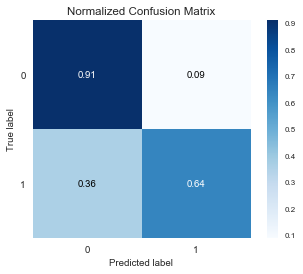

In [113]:
skplt.metrics.plot_confusion_matrix(valid_y, pred_y, normalize=True)
plt.show()

---

#### Random Forest Classifier

- logistic regression 보다 성능 낮음

In [114]:
from sklearn.ensemble import RandomForestClassifier

clf3 = RandomForestClassifier(max_depth=3, random_state=0)
clf3.fit(train_x, train_y)
pred_y = clf3.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 32


In [115]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.79
Precision : 0.765
Recall : 0.661
F1 : 0.709


#### SVC & Xgboost

In [116]:
from sklearn.svm import SVC
clf4 = SVC(kernel='linear', C=1.0, random_state=0)

clf4.fit(train_x, train_y)
pred_y = clf4.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 28


In [117]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.81
Precision : 0.763
Recall : 0.763
F1 : 0.763


In [118]:
from xgboost import XGBClassifier

clf5 = XGBClassifier()
clf5.fit(train_x, train_y)
pred_y = clf5.predict(valid_x)

print("Misclassification samples : %d" %(valid_y != pred_y).sum())

Misclassification samples : 27


In [119]:
print("accuracy: %.2f" %accuracy_score(valid_y, pred_y))
print("Precision : %.3f" % precision_score(valid_y, pred_y))
print("Recall : %.3f" % recall_score(valid_y, pred_y))
print("F1 : %.3f" % f1_score(valid_y, pred_y))

accuracy: 0.82
Precision : 0.833
Recall : 0.678
F1 : 0.748


-----

-----

### 10. 최종 모델 선택 후(xgboost), 교차검증을 통한 과적합 확인

In [120]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(lr, train_x, train_y, cv=10)
print(scores)

[ 0.75        0.7         0.75        0.8         0.8         0.77966102
  0.74576271  0.84482759  0.79310345  0.81034483]


In [121]:
scores = cross_val_score(clf2, train_x, train_y, cv=10)
print(scores)

[ 0.8         0.73333333  0.71666667  0.78333333  0.81666667  0.77966102
  0.72881356  0.82758621  0.75862069  0.77586207]


In [122]:
scores = cross_val_score(clf3, train_x, train_y, cv=10)
print(scores)

[ 0.78333333  0.78333333  0.8         0.78333333  0.8         0.79661017
  0.77966102  0.79310345  0.79310345  0.81034483]


In [123]:
scores = cross_val_score(clf4, train_x, train_y, cv=10)
print(scores)

[ 0.7         0.65        0.75        0.8         0.75        0.81355932
  0.81355932  0.74137931  0.79310345  0.74137931]


In [124]:
scores = cross_val_score(clf5, train_x, train_y, cv=10)
print(scores)

[ 0.8         0.76666667  0.75        0.78333333  0.81666667  0.77966102
  0.76271186  0.84482759  0.82758621  0.77586207]


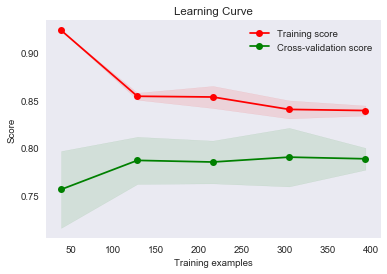

In [125]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(clf5, train_x, train_y)
plt.show()

-----

-----

### 11. 테스트셋으로 최종 평가

In [126]:
titanic = pd.read_csv("dataset/titanic_answer.csv")
titanic = titanic.drop(['ticket', 'body', 'home.dest'], axis=1)

# age : 결측값은 평균으로 보정, child와 non-child로 구분하여 새로운 피처 생성
titanic['age'] = titanic['age'].fillna(titanic['age'].mean())
titanic['child'] = 0
titanic.loc[titanic['age'] < 18, 'child'] = 1
titanic = titanic.drop(['age'], axis=1)

# fare : rich와 non-rich로 구분하여 새로운 피처 생성
titanic['royal'] = 0
titanic.loc[titanic['fare'] > 10, 'royal'] = 1
titanic = titanic.drop(['fare'], axis=1)

# sex : male은 0, female은 1로 변환
titanic.loc[titanic['sex']=='male', 'sex'] = 0
titanic.loc[titanic['sex']=='female', 'sex'] = 1

# embark : 2개의 결측값은 최빈값으로 대체하고, one hot encoding 적용
embarked_mode = titanic['embarked'].value_counts().index[0]
titanic['embarked'] = titanic['embarked'].fillna(embarked_mode)

df_one_hot_encoded = pd.get_dummies(titanic.embarked)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['embarked'], axis=1)

# cabin : 없는 경우, G나 T는 X로 대체한 뒤 one hot encoding 적용
titanic['cabin'] = titanic['cabin'].fillna('X')
titanic['cabin'] = titanic['cabin'].apply(lambda x: x[0])
titanic['cabin'] = titanic['cabin'].replace({"G":"X", "T":"X"})

df_one_hot_encoded = pd.get_dummies(titanic.cabin)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['cabin'], axis=1)

# 호칭에 따라 등급을 분류하는 함수. 같은 호칭을 부르는 말은 같은 grade로 통합
def mr_grade(row):
    # 명예직
    if 'Rev.' in row:
        return "A"
    elif 'Col.' in row:
        return "A"
    elif 'Major.' in row:
        return "A"
    elif 'Dr.' in row:
        return "A"
    elif 'Capt.' in row:
        return "A"
    elif 'Sir.' in row:
        return "A"
    # 여성
    elif 'Ms.' in row:
        return "B"
    elif 'Mme.' in row:
        return "B"
    elif 'Mrs.' in row:
        return "B"
    elif 'Dona.' in row:
        return "D"
    # 귀족, 작위
    elif 'Jonkheer.' in row:
        return "C"
    elif 'Countess.' in row:
        return "C"
    # 남성
    elif 'Mr.' in row:
        return "D"
    elif 'Don.' in row:
        return "D"
    # 젊은남성
    elif 'Master.' in row:
        return "E"
    # 젊은여성
    elif 'Miss.' in row:
        return "F"
    elif 'Mlle.' in row:
        return "F"
    elif 'Lady.' in row:
        return "F"
    else:
        return "G"

# name_grade 피처 생성하고 one-hot encoding 적용
titanic['name'] = titanic.apply(lambda row: mr_grade(row['name']), axis=1)

df_one_hot_encoded = pd.get_dummies(titanic.name)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['name'], axis=1)

# pclass one-hot encoding 적용
df_one_hot_encoded = pd.get_dummies(titanic.pclass)
titanic = pd.concat([titanic, df_one_hot_encoded], axis=1)
titanic = titanic.drop(['pclass'], axis=1)

titanic.columns = ['survived',      'sex',    'sibsp',    'parch',    'child',    'royal',
              'C1',        'Q',        'S',        'A1',        'B1',        'C2',
              'D1',        'E1',        'F1',        'X',        'A2',        'B2',
              'D2',        'E2',        'F2',          1,          2,         3]
#titanic['C3'] = 0
titanic.insert(loc=18, column='C3', value=0)
titanic.head()

answer_y = titanic['survived']
answer_x = titanic.drop(['survived'], axis=1)

In [127]:
pred_y = lr.predict(answer_x)
print("Misclassification samples : %d" %(answer_y != pred_y).sum())

print("accuracy: %.2f" %accuracy_score(answer_y, pred_y))
print("Precision : %.3f" % precision_score(answer_y, pred_y))
print("Recall : %.3f" % recall_score(answer_y, pred_y))
print("F1 : %.3f" % f1_score(answer_y, pred_y))

Misclassification samples : 81
accuracy: 0.79
Precision : 0.758
Recall : 0.660
F1 : 0.705


In [128]:
pred_y = clf2.predict(answer_x)
print("Misclassification samples : %d" %(answer_y != pred_y).sum())

print("accuracy: %.2f" %accuracy_score(answer_y, pred_y))
print("Precision : %.3f" % precision_score(answer_y, pred_y))
print("Recall : %.3f" % recall_score(answer_y, pred_y))
print("F1 : %.3f" % f1_score(answer_y, pred_y))

Misclassification samples : 90
accuracy: 0.77
Precision : 0.777
Recall : 0.544
F1 : 0.640


In [129]:
pred_y = clf3.predict(answer_x)
print("Misclassification samples : %d" %(answer_y != pred_y).sum())

print("accuracy: %.2f" %accuracy_score(answer_y, pred_y))
print("Precision : %.3f" % precision_score(answer_y, pred_y))
print("Recall : %.3f" % recall_score(answer_y, pred_y))
print("F1 : %.3f" % f1_score(answer_y, pred_y))

Misclassification samples : 79
accuracy: 0.80
Precision : 0.788
Recall : 0.633
F1 : 0.702


In [130]:
pred_y = clf4.predict(answer_x)
print("Misclassification samples : %d" %(answer_y != pred_y).sum())

print("accuracy: %.2f" %accuracy_score(answer_y, pred_y))
print("Precision : %.3f" % precision_score(answer_y, pred_y))
print("Recall : %.3f" % recall_score(answer_y, pred_y))
print("F1 : %.3f" % f1_score(answer_y, pred_y))

Misclassification samples : 79
accuracy: 0.80
Precision : 0.746
Recall : 0.701
F1 : 0.723


In [131]:
pred_y = clf5.predict(answer_x)
print("Misclassification samples : %d" %(answer_y != pred_y).sum())

print("accuracy: %.2f" %accuracy_score(answer_y, pred_y))
print("Precision : %.3f" % precision_score(answer_y, pred_y))
print("Recall : %.3f" % recall_score(answer_y, pred_y))
print("F1 : %.3f" % f1_score(answer_y, pred_y))

Misclassification samples : 80
accuracy: 0.80
Precision : 0.813
Recall : 0.592
F1 : 0.685


# 결론 : SVC을 이용한 학습모델이 Best!